# Setup

## Install [MINE](https://stackoverflow.com/questions/51869713/how-to-read-edf-data-in-python-3)

In [ ]:
!pip install mne
!pip install sklearn
import mne

     |████████████████████████████████| 6.8MB 3.9MB/s 
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

## Install PyWavelets

In [ ]:
!pip install PyWavelets

## Imports

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import minmax_scale

import gdown
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

from scipy import signal
import pywt

from scipy.fft import fft, ifft

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import regularizers


# Data

Current ones are binary and multi-class BCI Competition IV datasets

## BCI Competition Dataset 2b ([here](http://bbci.de/competition/iv/desc_2b.pdf))

In [ ]:
url = 'https://drive.google.com/uc?id=1r6ITfjPk4HCyo57eBAyOoyKHiYqin9DJ'
output = 'bciciv2b.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1r6ITfjPk4HCyo57eBAyOoyKHiYqin9DJ
To: /content/bciciv2b.zip
227MB [00:01, 136MB/s] 


'bciciv2b.zip'

## BCI Competition Dataset 2a ([here](http://bbci.de/competition/iv/desc_2a.pdf))

In [ ]:
url = 'https://drive.google.com/uc?id=1FPyXUpFMBYTw6pK2P9fehUVlt-6XwWOL'
output = 'bciciv2a.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FPyXUpFMBYTw6pK2P9fehUVlt-6XwWOL
To: /content/bciciv2a.zip
440MB [00:04, 108MB/s]


'bciciv2a.zip'

## Unzipping (Must be either/or)

In [ ]:
!rm *.gdf
!rm -rf files

rm: cannot remove '*.gdf': No such file or directory


In [ ]:
!mkdir 2a 2b

In [ ]:
#!unzip bciciv2b.zip
!unzip bciciv2a.zip && mv *.gdf 2a
!unzip bciciv2b.zip && mv *.gdf 2b

Archive:  bciciv2a.zip
  inflating: A01E.gdf                
  inflating: A01T.gdf                
  inflating: A02E.gdf                
  inflating: A02T.gdf                
  inflating: A03E.gdf                
  inflating: A03T.gdf                
  inflating: A04E.gdf                
  inflating: A04T.gdf                
  inflating: A05E.gdf                
  inflating: A05T.gdf                
  inflating: A06E.gdf                
  inflating: A06T.gdf                
  inflating: A07E.gdf                
  inflating: A07T.gdf                
  inflating: A08E.gdf                
  inflating: A08T.gdf                
  inflating: A09E.gdf                
  inflating: A09T.gdf                
Archive:  bciciv2b.zip
  inflating: B0101T.gdf              
  inflating: B0102T.gdf              
  inflating: B0103T.gdf              
  inflating: B0104E.gdf              
  inflating: B0105E.gdf              
  inflating: B0201T.gdf              
  inflating: B0202T.gdf              
  in

In [ ]:
!ls
!ls 2a | head -5
!ls 2b | head -5

2a  2b	bciciv2a.zip  bciciv2b.zip  sample_data
A01E.gdf
A01T.gdf
A02E.gdf
A02T.gdf
A03E.gdf
B0101T.gdf
B0102T.gdf
B0103T.gdf
B0104E.gdf
B0105E.gdf


### Example Data

### Construct `X`/`y` arrays
> Note that the class labels (i. e., 1 and 2, corresponding to event types
769 and 770) are only provided for the training data and not for the testing
data.

Basically, grab `769`'s as class 1 and `770`'s as class 2

In [ ]:
!cp files/S001/S001R01.edf.event files/S001/S001R01_a.edf

cp: cannot stat 'files/S001/S001R01.edf.event': No such file or directory


In [ ]:
"""
file = 'files/A05T.gdf'#"B0102T.gdf"#files/S001/S001R01.edf"
data = mne.io.read_raw_gdf(file)#, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])#edf(file)
#l = dir(data)
#pprint(l)

raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
anno = data.annotations
channels = data.ch_names

print(channels)

break
"""

classes_2b = ["770", "769"]
recording_class_2b = '768'
reject_class_2b = '1023'
classes_2a = ["769", "770", "771", "772"]

DATASET = 'b'
REMOVE_BASELINE = False
SPECTROGRAM = False
GEN_CWT = False
GET_FFT = False
TRIM_CUE = False

#print(channels)
#print(info)
#print(anno)
X = []
X_channeled = []
X_more = []
Y_more = []
Y = []
Sxx = []
abs_max_x = 0
abs_min_x = 0
CWT = []
abs_max_cwt = 0
abs_min_cwt = 0

ffts = {0: [], 1: []}
eegs = {0: [], 1: []}

scales = np.arange(1, 128) # range of scales
wavelet = 'morl' # mother wavelet

def feature_normalize(dataset):
    return (dataset - np.mean(dataset, axis=0))/np.std(dataset, axis=0)

classes = classes_2a if DATASET is 'a' else classes_2b

for trial in tqdm(glob('2' + DATASET + '/*gdf')):
  #print(trial)

  if DATASET is 'b':
    data = mne.io.read_raw_gdf(trial, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])#edf(file)
  else:
    data = mne.io.read_raw_gdf(trial, eog=['EOG-left', 'EOG-central', 'EOG-right'])#edf(file)
  #l = dir(data)
  #pprint(l)

  raw_data = data.get_data()
  # you can get the metadata included in the file and a list of all channels:
  info = data.info
  anno = data.annotations
  channels = data.ch_names

  #print(trial.split('/')[-1].split('.')[0][-3:])
  if trial.split('/')[-1].split('.')[0][-3:] not in ['01T', '02T'] and DATASET is 'b':
    continue
  print(trial)
  #print("\nANNOTATIONS:\n{}".format(anno))

  print(list(zip(anno, anno[1:]))[:2])

  # trial annotations are of form TRIAL_START, CUE_TYPE/REJECT
  for a1, a2 in zip(anno, anno[1:]):
    
    if a1['description'] != recording_class_2b:
      continue
    if a2['description'] == reject_class_2b:
      continue
    #print("trial annotation {}".format(a1))
    #print("secondary annotation {}".format(a2))
    #continue
    """
    #print(a)
    if a['description'] == '769':
      y = 1
    elif a['description'] == '770':
      y = 0
    else:
      continue
    """

    if DATASET is 'b' and a2['description'] not in classes:
      continue
    
    y = classes.index(a2['description'])#a['description'])
    #print("y: {}".format(y))

    # difference from before: need to trim the trial to just the first 4 seconds
    # (removing the cue!)
    
    #continue
    
    cue_duration = int(a2['duration'] * 1000)
    #print("cue duration: {}".format(cue_duration / 1000.))
    #continue

    # added: trim off the cue! (First cue_duration ms)
    if TRIM_CUE:
      start_ms = int(a2['onset'] * 1000) + cue_duration#int(a1['onset'] * 1000) + cue_duration
      end_ms = int(a1['onset'] * 1000 + a1['duration'] * 1000)#start_ms + a1['duration'] * 1000) - cue_duration
    else:
      start_ms = int(a2['onset'] * 1000)
      end_ms = int(a1['onset'] * 1000 + a1['duration'] * 1000)

    # sampling period is 4 ms 
    start_index = int(start_ms / 4)
    end_index = int(end_ms / 4)

    eeg_0 = raw_data[0, start_index:end_index] # replace this w/ df access later
    eeg_1 = raw_data[1, start_index:end_index]
    eeg_2 = raw_data[2, start_index:end_index]

    #print(eeg_0.shape)
    #plt.plot(eeg_0)
    #continue

    if REMOVE_BASELINE:
      eeg_0 -= np.mean(eeg_0)
      eeg_1 -= np.mean(eeg_1)
      eeg_2 -= np.mean(eeg_2)

    """ spectrogram """
    if SPECTROGRAM:
      fs = 250
      _, _, Sxx_0 = signal.spectrogram(eeg_0, fs=fs, nperseg=25)
      _, _, Sxx_1 = signal.spectrogram(eeg_1, fs=fs, nperseg=25)
      _, _, Sxx_2 = signal.spectrogram(eeg_2, fs=fs, nperseg=25)
      Sxx_0 = np.swapaxes(Sxx_0, 0, 1)
      Sxx_1 = np.swapaxes(Sxx_1, 0, 1)
      Sxx_2 = np.swapaxes(Sxx_2, 0, 1)
      Sxx_0 = Sxx_0.reshape((Sxx_0.shape[0], Sxx_0.shape[1], 1))
      Sxx_1 = Sxx_1.reshape((Sxx_1.shape[0], Sxx_1.shape[1], 1))
      Sxx_2 = Sxx_2.reshape((Sxx_2.shape[0], Sxx_2.shape[1], 1))

      Sxx.extend([Sxx_0, Sxx_1, Sxx_2])
    
    if GEN_CWT:
      # apply  PyWavelets continuous wavelet transfromation function
      coeffs_0, _ = pywt.cwt(eeg_0, scales, wavelet = wavelet)
      coeffs_1, _ = pywt.cwt(eeg_1, scales, wavelet = wavelet)
      coeffs_2, _ = pywt.cwt(eeg_2, scales, wavelet = wavelet)

      coeff_x = coeffs_0.shape[0]
      coeff_y = coeffs_0.shape[1]
      coeffs_0 = coeffs_0.reshape((coeff_x, coeff_y, 1))
      coeffs_1 = coeffs_1.reshape((coeff_x, coeff_y, 1))
      coeffs_2 = coeffs_2.reshape((coeff_x, coeff_y, 1))

      min_cwt = np.min(np.array([coeffs_0, coeffs_1, coeffs_2]))
      max_cwt = np.max(np.array([coeffs_0, coeffs_1, coeffs_2]))

      if min_cwt < abs_min_cwt:
        abs_min_cwt = min_cwt
      if max_cwt > abs_max_cwt:
        abs_max_cwt = max_cwt

      CWT.extend([coeffs_0, coeffs_1, coeffs_2])

    if GET_FFT:
      fft_0 = np.abs(fft(eeg_0))
      fft_1 = np.abs(fft(eeg_1))
      fft_2 = np.abs(fft(eeg_2))
      ffts[y].extend([fft_0, fft_1, fft_2])

    eeg_x = np.hstack((eeg_0, eeg_1, eeg_2)) # this could be a reshape, eh
    eeg_channeled = [[x, y, z] for x,y,z in zip(eeg_0, eeg_1, eeg_2)]#raw_data[:3, start_index:end_index]

    eegs[y].append(eeg_channeled)

    min_x = np.min(eeg_x)
    max_x = np.max(eeg_x)

    if min_x < abs_min_x:
      abs_min_x = min_x
    if max_x > abs_max_x:
      abs_max_x = max_x
    
    X.append(np.array(eeg_x))
    X_channeled.append(eeg_channeled)

    X_more.extend([eeg_0, eeg_1, eeg_2])
    Y_more.extend([np.array(y), np.array(y), np.array(y)])
    Y.append(np.array(y))

"""
# old normalization was wrong!
X = [minmax_scale(x.ravel(), feature_range=(0.0,1.0)).reshape(x.shape) for x in X]
X_channeled = [minmax_scale(x.ravel(), feature_range=(0.0,1.0)).reshape(x.shape) for x in X_channeled]
"""

X = np.array(X)
Y_channeled = Y
Y = np.array(Y)

X_more = np.array(X_more)
Y_more = np.array(Y_more)
#X_channeled = np.array(X_channeled)

  0%|          | 0/45 [00:00<?, ?it/s]

Extracting EDF parameters from /content/2b/B0802T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
  2%|▏         | 1/45 [00:01<00:57,  1.30s/it]

2b/B0802T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 12, 2, 10, 18, 33, 980003, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 12, 2, 10, 18, 33, 980003, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 12, 2, 10, 18, 33, 980003, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 12, 2, 10, 18, 33, 980003, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0603T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
  4%|▍         | 2/45 [00:02<00:50,  1.18s/it]

Extracting EDF parameters from /content/2b/B0303T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
  7%|▋         | 3/45 [00:03<00:45,  1.09s/it]

Extracting EDF parameters from /content/2b/B0803T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
  9%|▉         | 4/45 [00:03<00:42,  1.04s/it]

Extracting EDF parameters from /content/2b/B0302T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 11%|█         | 5/45 [00:05<00:44,  1.10s/it]

2b/B0302T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 17, 10, 12, 22, 669988, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 17, 10, 12, 22, 669988, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 17, 10, 12, 22, 669988, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 17, 10, 12, 22, 669988, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0804E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 13%|█▎        | 6/45 [00:06<00:40,  1.04s/it]

Extracting EDF parameters from /content/2b/B0402T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 16%|█▌        | 7/45 [00:07<00:44,  1.16s/it]

2b/B0402T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 7, 12, 38, 31, 479999, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 7, 12, 38, 31, 479999, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 7, 12, 38, 31, 479999, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 7, 12, 38, 31, 479999, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0602T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 18%|█▊        | 8/45 [00:08<00:43,  1.19s/it]

2b/B0602T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 2, 10, 19, 7, 419995, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 10, 19, 7, 419995, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 10, 19, 7, 419995, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 2, 10, 19, 7, 419995, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0103T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 20%|██        | 9/45 [00:09<00:39,  1.09s/it]

Extracting EDF parameters from /content/2b/B0801T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 22%|██▏       | 10/45 [00:11<00:43,  1.25s/it]

2b/B0801T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 21, 9, 19, 10, 9996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 21, 9, 19, 10, 9996, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 21, 9, 19, 10, 9996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 21, 9, 19, 10, 9996, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0903T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 24%|██▍       | 11/45 [00:12<00:38,  1.13s/it]

Extracting EDF parameters from /content/2b/B0403T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 27%|██▋       | 12/45 [00:13<00:34,  1.05s/it]

Extracting EDF parameters from /content/2b/B0905E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 29%|██▉       | 13/45 [00:13<00:31,  1.01it/s]

Extracting EDF parameters from /content/2b/B0605E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 31%|███       | 14/45 [00:14<00:29,  1.05it/s]

Extracting EDF parameters from /content/2b/B0301T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 33%|███▎      | 15/45 [00:16<00:31,  1.05s/it]

2b/B0301T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 2, 15, 37, 16, 529993, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 15, 37, 16, 529993, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 15, 37, 16, 529993, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 2, 15, 37, 16, 529993, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0504E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 36%|███▌      | 16/45 [00:16<00:28,  1.03it/s]

Extracting EDF parameters from /content/2b/B0304E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 38%|███▊      | 17/45 [00:17<00:26,  1.07it/s]

Extracting EDF parameters from /content/2b/B0101T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 40%|████      | 18/45 [00:18<00:27,  1.01s/it]

2b/B0101T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 10, 25, 9, 35, 11, 149985, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 25, 9, 35, 11, 149985, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 25, 9, 35, 11, 149985, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 10, 25, 9, 35, 11, 149985, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0901T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 42%|████▏     | 19/45 [00:20<00:28,  1.09s/it]

2b/B0901T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 29, 14, 19, 32, 179996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 29, 14, 19, 32, 179996, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 29, 14, 19, 32, 179996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 29, 14, 19, 32, 179996, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0102T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 44%|████▍     | 20/45 [00:21<00:27,  1.09s/it]

2b/B0102T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 7, 16, 38, 57, 709998, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 20.592), ('duration', 8.0), ('description', '768'), ('orig_time', datetime.datetime(2005, 11, 7, 16, 38, 57, 709998, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 20.592), ('duration', 8.0), ('description', '768'), ('orig_time', datetime.datetime(2005, 11, 7, 16, 38, 57, 709998, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 20.592), ('duration', 8.0), ('description', '1023'), ('orig_time', datetime.datetime(2005, 11, 7, 16, 38, 57, 709998, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0202T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 47%|████▋     | 21/45 [00:22<00:26,  1.11s/it]

2b/B0202T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 10, 31, 10, 47, 27, 70000, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 31, 10, 47, 27, 70000, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 31, 10, 47, 27, 70000, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 10, 31, 10, 47, 27, 70000, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0902T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


2b/B0902T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 12, 6, 10, 16, 49, 99985, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 12, 6, 10, 16, 49, 99985, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 12, 6, 10, 16, 49, 99985, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 12, 6, 10, 16, 49, 99985, tzinfo=datetime.timezone.utc))]))]


 49%|████▉     | 22/45 [00:23<00:27,  1.18s/it]

Extracting EDF parameters from /content/2b/B0105E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 51%|█████     | 23/45 [00:24<00:24,  1.10s/it]

Extracting EDF parameters from /content/2b/B0604E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 53%|█████▎    | 24/45 [00:25<00:21,  1.03s/it]

Extracting EDF parameters from /content/2b/B0704E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 56%|█████▌    | 25/45 [00:26<00:19,  1.01it/s]

Extracting EDF parameters from /content/2b/B0401T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 58%|█████▊    | 26/45 [00:27<00:19,  1.04s/it]

2b/B0401T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 3, 11, 29, 51, 369999, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 3, 11, 29, 51, 369999, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 3, 11, 29, 51, 369999, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 3, 11, 29, 51, 369999, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0705E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 60%|██████    | 27/45 [00:28<00:17,  1.02it/s]

Extracting EDF parameters from /content/2b/B0203T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 62%|██████▏   | 28/45 [00:29<00:16,  1.06it/s]

Extracting EDF parameters from /content/2b/B0502T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


2b/B0502T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 2, 12, 55, 35, 979994, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 12, 55, 35, 979994, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 2, 12, 55, 35, 979994, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 2, 12, 55, 35, 979994, tzinfo=datetime.timezone.utc))]))]


 64%|██████▍   | 29/45 [00:30<00:18,  1.13s/it]

Extracting EDF parameters from /content/2b/B0805E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 67%|██████▋   | 30/45 [00:31<00:15,  1.05s/it]

Extracting EDF parameters from /content/2b/B0701T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 69%|██████▉   | 31/45 [00:32<00:15,  1.08s/it]

2b/B0701T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 22, 10, 6, 12, 529992, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 22, 10, 6, 12, 529992, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 22, 10, 6, 12, 529992, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 22, 10, 6, 12, 529992, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0204E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 71%|███████   | 32/45 [00:33<00:12,  1.03it/s]

Extracting EDF parameters from /content/2b/B0703T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 73%|███████▎  | 33/45 [00:34<00:11,  1.06it/s]

Extracting EDF parameters from /content/2b/B0501T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 76%|███████▌  | 34/45 [00:35<00:11,  1.02s/it]

2b/B0501T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 10, 24, 13, 3, 40, 209997, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 24, 13, 3, 40, 209997, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 24, 13, 3, 40, 209997, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 10, 24, 13, 3, 40, 209997, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0405E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 78%|███████▊  | 35/45 [00:36<00:09,  1.03it/s]

Extracting EDF parameters from /content/2b/B0404E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 80%|████████  | 36/45 [00:37<00:08,  1.06it/s]

Extracting EDF parameters from /content/2b/B0201T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 82%|████████▏ | 37/45 [00:38<00:08,  1.01s/it]

2b/B0201T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 10, 25, 11, 59, 13, 179996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 25, 11, 59, 13, 179996, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 25, 11, 59, 13, 179996, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 10, 25, 11, 59, 13, 179996, tzinfo=datetime.timezone.utc))]))]
Extracting EDF parameters from /content/2b/B0904E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 84%|████████▍ | 38/45 [00:39<00:06,  1.04it/s]

Extracting EDF parameters from /content/2b/B0601T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


2b/B0601T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 10, 28, 10, 3, 22, 539986, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 28, 10, 3, 22, 539986, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 10, 28, 10, 3, 22, 539986, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 10, 28, 10, 3, 22, 539986, tzinfo=datetime.timezone.utc))]))]


 87%|████████▋ | 39/45 [00:40<00:06,  1.09s/it]

Extracting EDF parameters from /content/2b/B0104E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 89%|████████▉ | 40/45 [00:41<00:05,  1.03s/it]

Extracting EDF parameters from /content/2b/B0503T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 91%|█████████ | 41/45 [00:42<00:03,  1.02it/s]

Extracting EDF parameters from /content/2b/B0505E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 93%|█████████▎| 42/45 [00:43<00:02,  1.06it/s]

Extracting EDF parameters from /content/2b/B0305E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 96%|█████████▌| 43/45 [00:44<00:01,  1.09it/s]

Extracting EDF parameters from /content/2b/B0205E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
 98%|█████████▊| 44/45 [00:45<00:00,  1.11it/s]

Extracting EDF parameters from /content/2b/B0702T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.6/dist-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
100%|██████████| 45/45 [00:46<00:00,  1.03s/it]

2b/B0702T.gdf
[(OrderedDict([('onset', 0.0), ('duration', 0.004), ('description', '32766'), ('orig_time', datetime.datetime(2005, 11, 24, 10, 31, 57, 510004, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 24, 10, 31, 57, 510004, tzinfo=datetime.timezone.utc))])), (OrderedDict([('onset', 1.996), ('duration', 60.0), ('description', '276'), ('orig_time', datetime.datetime(2005, 11, 24, 10, 31, 57, 510004, tzinfo=datetime.timezone.utc))]), OrderedDict([('onset', 66.996), ('duration', 60.0), ('description', '277'), ('orig_time', datetime.datetime(2005, 11, 24, 10, 31, 57, 510004, tzinfo=datetime.timezone.utc))]))]


### Normalization

In [ ]:
# proper normalization
# scaling
X = (X - abs_min_x) / (abs_max_x - abs_min_x)
# same for X_more
X_more = (X_more - abs_min_x) / (abs_max_x - abs_min_x)
# same for X_channeled
X_channeled = [np.array(xc) for xc in X_channeled]
"""
for axs in [0, 1, 2]:
  channel_max = np.max(np.array(X_channeled)[:, :, axs]
"""
#X_channeled = [(xc - abs_min_x) / (abs_max_x - abs_min_x) for xc in X_channeled]
#X_channeled = (X_channeled - abs_min_x) / (abs_max_x - abs_min_x)
if GEN_CWT:
  CWT = [(cwt - abs_min_cwt) / (abs_max_cwt - abs_min_cwt) for cwt in CWT]

print(len(X), len(Y))
print(abs_max_x, abs_min_x)
print(X[0].shape, Y[0].shape)
print(np.unique(X), np.unique(Y))

1844 1844
5.79690241855497e-05 -5.566491187914855e-05
(3750,) ()
[0.         0.00931919 0.01315966 ... 0.96758426 0.96903451 1.        ] [0 1]


## Saving (Channeled) Data

In [ ]:
np.save("X_channeled.npy", np.array(X_channeled))
np.save("Y.npy", Y)

## Load (Channeled) Data

### Install `gdown`

In [5]:
!pip install gdown
import gdown

In [6]:
for arr_type, file_id in {'X_channeled.npy': '1muCIkQQbbj0xyszJQVhbBdVoKIU80EyH', 'Y.npy': '1bqAANOik__tj4XqTxF0g4P4eVYYV75w5'}.items():
  url = 'https://drive.google.com/uc?id={}'.format(file_id)
  output = arr_type
  gdown.download(url, output, quiet=False)

X_channeled = np.load('X_channeled.npy')
Y = np.load('Y.npy')

Downloading...
From: https://drive.google.com/uc?id=1muCIkQQbbj0xyszJQVhbBdVoKIU80EyH
To: /content/X_channeled.npy
55.3MB [00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bqAANOik__tj4XqTxF0g4P4eVYYV75w5
To: /content/Y.npy
100%|██████████| 14.9k/14.9k [00:00<00:00, 3.54MB/s]


### Convert `X_channeled` batch axis to list (for now)

In [7]:
X_channeled = [X_channeled[i] for i in range(X_channeled.shape[0])]
Y_channeled = [Y[i] for i in range(Y.shape[0])]

## Visualizations

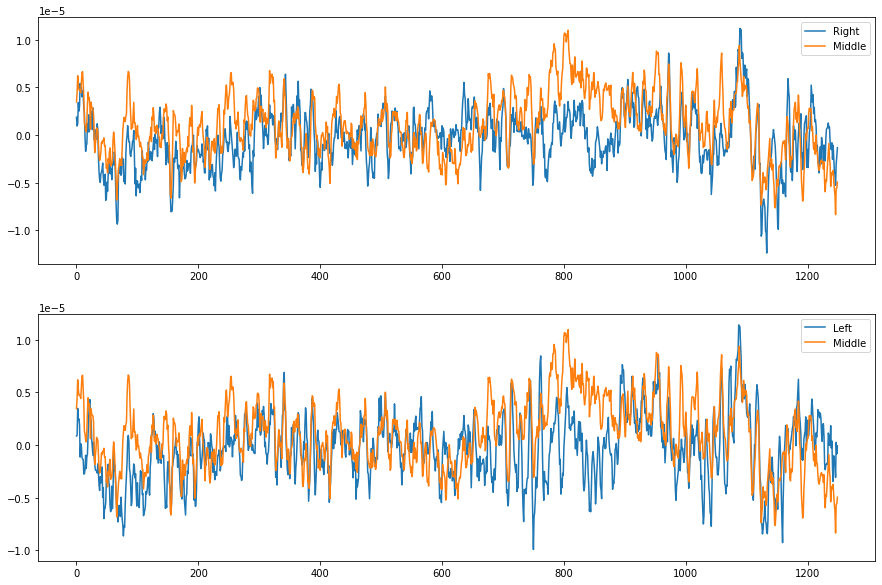

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
for idx in range(2):
  if Y[idx] == 1:
    axs[0].plot(X_channeled[idx][ :, 0])
    axs[0].plot(X_channeled[idx][ :, 1])
    axs[0].legend(["Right", "Middle"])
    axs[1].plot(X_channeled[idx][ :, 2])
    axs[1].plot(X_channeled[idx][ :, 1])
    axs[1].legend(["Left", "Middle"])

## Subtracting the Middle

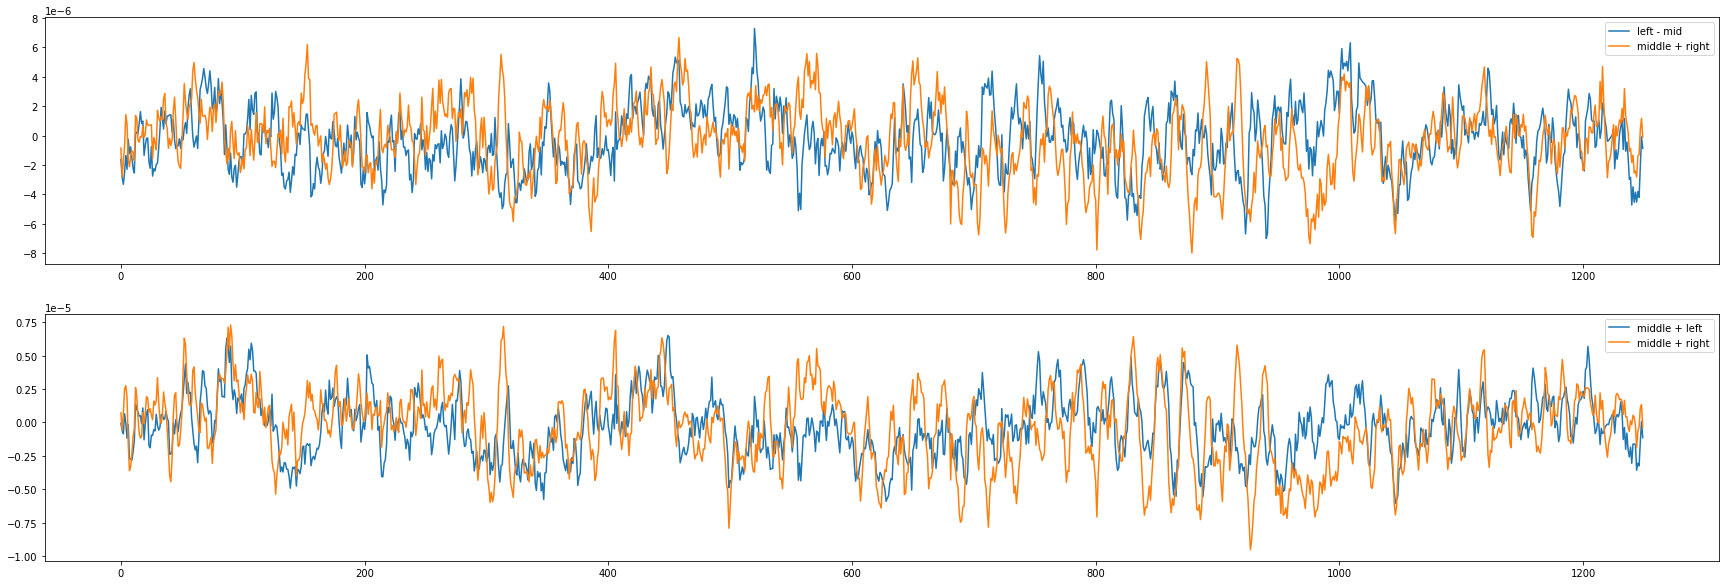

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(30, 10))
for idx in range(2):
  if Y[idx] == 1:
    mid = X_channeled[idx][ :, 1]
    l = X_channeled[idx][ :, 0]
    r = X_channeled[idx][ :, 2]
    
    axs[0].plot(l - mid)
    axs[0].plot(r - mid)
    axs[0].legend(["left - mid", "middle + right"])
    axs[1].plot(l)
    axs[1].plot(r)
    axs[1].legend(["middle + left", "middle + right"])
    """
    axs[0].psd(l)
    axs[0].psd(r)
    axs[1].psd(l - mid)
    axs[1].psd(r - mid)
    """

## LP-Filtering + Squaring Abs Differences

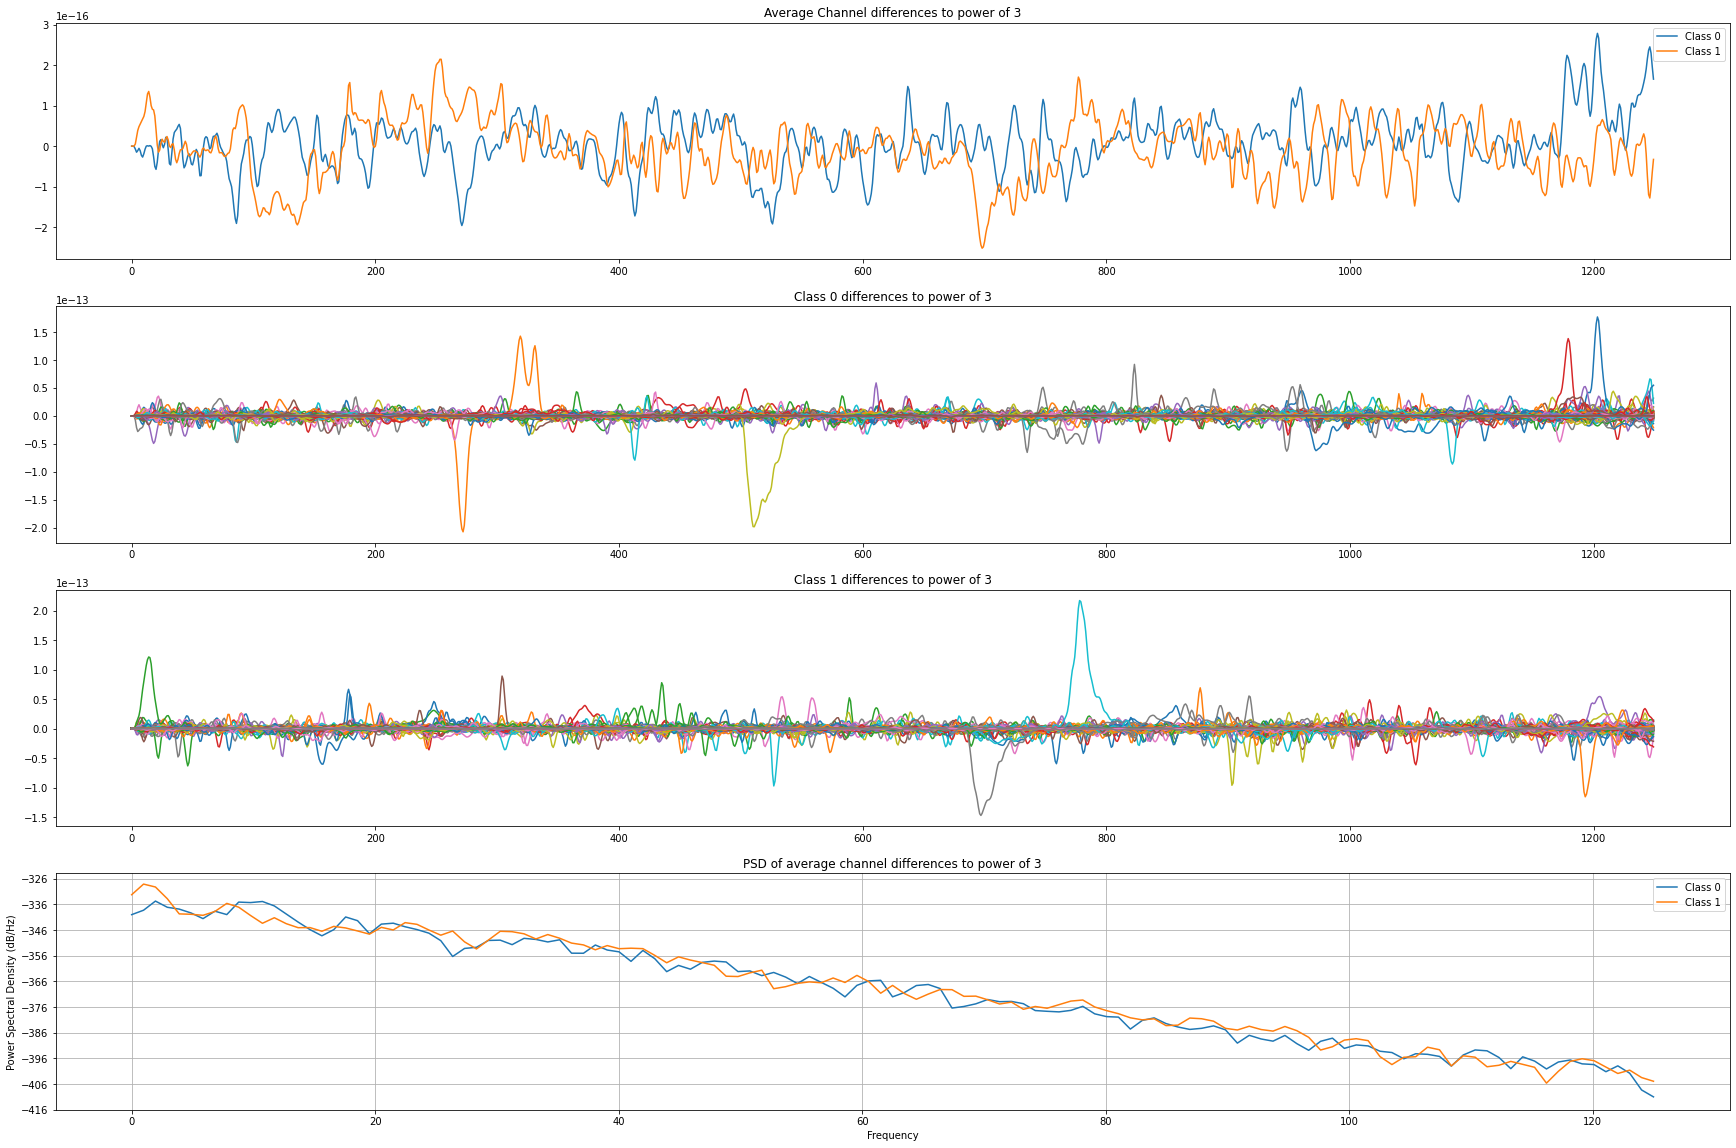

In [ ]:
from scipy.signal import butter, lfilter

NUM_TO_AVG = len(X_channeled)
PWR = 3

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

abs_diffs = {0: [], 1: []}
fig, axs = plt.subplots(4, 1, figsize=(30, 20))
for idx in range(NUM_TO_AVG):#2):
  if Y[idx] == 1:
    mid = X_channeled[idx][ :, 1]
    l = X_channeled[idx][ :, 0]
    r = X_channeled[idx][ :, 2]

    bp_l_25 = butter_bandpass_filter(l, 0.1, 25, 250, order=5)
    bp_l_50 = butter_bandpass_filter(l, 0.1, 50, 250, order=5)

    bp_r_25 = butter_bandpass_filter(r, 0.1, 25, 250, order=5)
    bp_r_50 = butter_bandpass_filter(r, 0.1, 50, 250, order=5)

    bp_l = bp_l_25 + bp_l_50
    bp_r = bp_r_25 + bp_r_50

    #axs[0].plot(np.abs(bp_l - bp_r) ** 2.0)
    
    # plot a bunch of powered diffs of this class
    axs[1].plot( (bp_l - bp_r) ** PWR )

    abs_diffs[0].append( (bp_l - bp_r) ** PWR )#np.abs(bp_l - bp_r) ** 2.0)

    """
    axs[0].plot(bp_l)
    axs[0].plot(bp_r)
    axs[0].legend(["BP'd L", "BP'd R"])
    """
    """
    axs[0].psd(bp_l_25)
    axs[0].psd(bp_r_25)
    axs[1].psd(bp_l)
    axs[1].psd(bp_r)
    #axs[1].psd(l)
    #axs[1].psd(r)
    #axs[1].set_xlim([0.0, 0.2])
    """
    """
    axs[1].plot(l)
    axs[1].plot(r)
    axs[1].legend([" L", " R"])
    """

    """
    axs[1].plot(l)
    axs[1].plot(r)
    axs[1].legend(["middle + left", "middle + right"])
    """
for idx in range(NUM_TO_AVG):#2):
  if Y[idx] == 0:
    mid = X_channeled[idx][ :, 1]
    l = X_channeled[idx][ :, 0]
    r = X_channeled[idx][ :, 2]

    bp_l_25 = butter_bandpass_filter(l, 0.1, 25, 250, order=5)
    bp_l_50 = butter_bandpass_filter(l, 0.1, 50, 250, order=5)

    bp_r_25 = butter_bandpass_filter(r, 0.1, 25, 250, order=5)
    bp_r_50 = butter_bandpass_filter(r, 0.1, 50, 250, order=5)

    bp_l = bp_l_25 + bp_l_50
    bp_r = bp_r_25 + bp_r_50

    #axs[1].plot(np.abs(bp_l - bp_r) ** 2.0)

    axs[2].plot( (bp_l - bp_r) ** PWR )

    # plot a bunch of powered diffs of this class
    abs_diffs[1].append( (bp_l - bp_r) ** PWR )#np.abs(bp_l - bp_r) ** 2.0)

abs_diffs_0 = np.mean(np.array(abs_diffs[0]), axis=0)
abs_diffs_1 = np.mean(np.array(abs_diffs[1]), axis=0)

# plot avg powered diffs
axs[0].plot(abs_diffs_0)
axs[0].plot(abs_diffs_1)

# compare spectral densities of powered diffs
axs[3].psd(abs_diffs_0, Fs=250)
axs[3].psd(abs_diffs_1, Fs=250)

axs[0].set_title("Average Channel differences to power of {}".format(PWR))
axs[0].legend(["Class 0", "Class 1"])
axs[1].set_title("Class 0 differences to power of {}".format(PWR))
axs[2].set_title("Class 1 differences to power of {}".format(PWR))
axs[3].set_title("PSD of average channel differences to power of {}".format(PWR))
axs[3].legend(["Class 0", "Class 1"])

### Avg (unwindowed) Power Spectra, 0 vs 1

In [ ]:
fft_class0 = np.array(ffts[0])
fft_class1 = np.array(ffts[1])
print(fft_class0.shape)
print(fft_class1.shape)
avg_fft_class0 = np.mean(fft_class0, axis=0)
avg_fft_class1 = np.mean(fft_class1, axis=0)
freq_bin = 250. / 313.
x_range = [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5]
x_full = [0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0]
hz = [round(x * freq_bin, 2) for x in x_range]
hz_full = [round(x * freq_bin, 2) for x in x_full]
plt.plot(avg_fft_class0[:165])
plt.plot(avg_fft_class1[:165])
plt.title("Average Power Spectra")
plt.xticks(x_full, hz_full)
plt.legend(["Class 0", "Class 1"])
plt.xlabel("Hz")
plt.ylabel("|fft|")
"""
plt.plot(avg_fft_class0[:20])
plt.plot(avg_fft_class1[:20])
plt.title("Average Power Spectra")
plt.xticks(x_range, hz)
plt.legend(["Class 0", "Class 1"])
plt.xlabel("Hz")
plt.ylabel("|fft|")
"""

### Avg (Channeled, Unwindowed) Power Spectra

In [ ]:
eeg_1 = eegs[1]
eeg_0 = eegs[0]

eeg_1 = np.array(eeg_1)
eeg_0 = np.array(eeg_0)

eeg_1 = (eeg_1 - abs_min_x) / (abs_max_x - abs_min_x)
eeg_0 = (eeg_0 - abs_min_x) / (abs_max_x - abs_min_x)
print(eeg_1.shape, eeg_0.shape)

(926, 937, 3) (918, 937, 3)


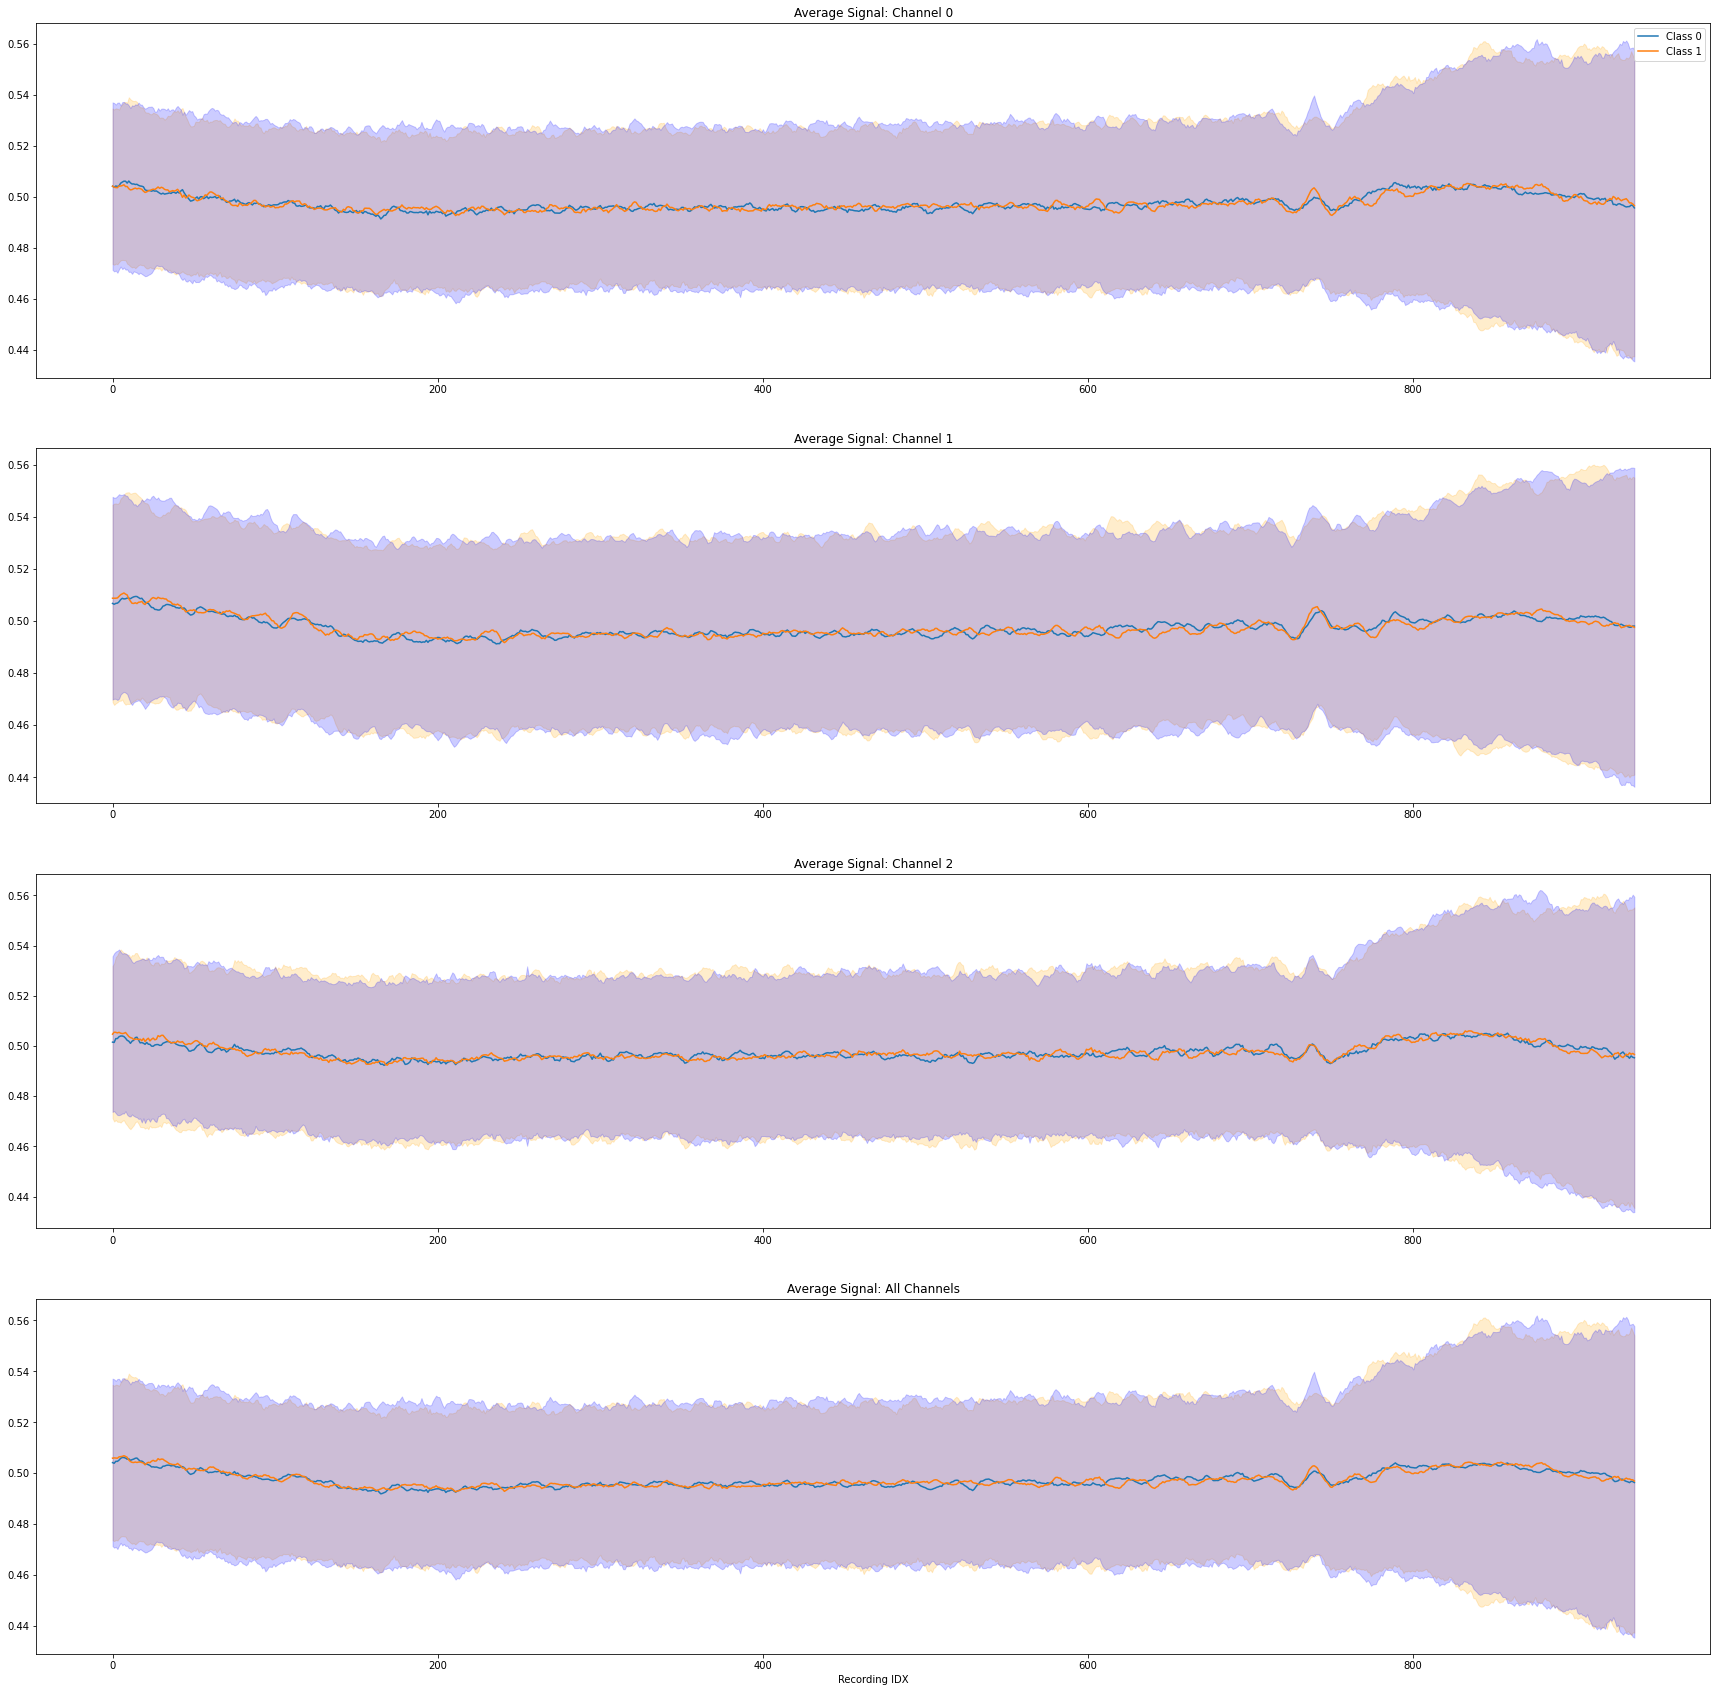

In [ ]:
eeg_1_channel_1 = eeg_1[:, :, 1]
eeg_0_channel_1 = eeg_0[:, :, 1]
eeg_1_channel_2 = eeg_1[:, :, 2]
eeg_0_channel_2 = eeg_0[:, :, 2]
eeg_1_channel_0 = eeg_1[:, :, 0]
eeg_0_channel_0 = eeg_0[:, :, 0]

avg_eeg_1_1 = np.mean(eeg_1_channel_1, axis=0)
avg_eeg_0_1 = np.mean(eeg_0_channel_1, axis=0)
var_eeg_1_1 = np.std(eeg_1_channel_1, axis=0)
var_eeg_0_1 = np.std(eeg_0_channel_1, axis=0)

avg_eeg_1_0 = np.mean(eeg_1_channel_0, axis=0)
avg_eeg_0_0 = np.mean(eeg_0_channel_0, axis=0)
var_eeg_1_0 = np.std(eeg_1_channel_0, axis=0)
var_eeg_0_0 = np.std(eeg_0_channel_0, axis=0)

avg_eeg_1_2 = np.mean(eeg_1_channel_2, axis=0)
avg_eeg_0_2 = np.mean(eeg_0_channel_2, axis=0)
var_eeg_1_2 = np.std(eeg_1_channel_2, axis=0)
var_eeg_0_2 = np.std(eeg_0_channel_2, axis=0)

avg_eeg_1 = np.mean(eeg_1, axis=(0, 2))
avg_eeg_0 = np.mean(eeg_0, axis=(0, 2))
var_eeg_1 = np.std(eeg_1, axis=(0, 2))
var_eeg_0 = np.std(eeg_0, axis=(0, 2))

"""
plt.plot(avg_eeg_0_1)
plt.plot(avg_eeg_1_1)
"""
XLIM=None#[250, 750]
x_range = np.array([i for i in range(937)])#1687)])

fig, axs = plt.subplots(4, 1, figsize=(30,30))
axs[0].plot(avg_eeg_0_0)
axs[0].plot(avg_eeg_1_0)
axs[0].fill_between(x_range, avg_eeg_0_0 - var_eeg_0_0, avg_eeg_0_0 + var_eeg_0_0,
                 color='orange', alpha=0.2)
axs[0].fill_between(x_range, avg_eeg_1_0 - var_eeg_1_0, avg_eeg_1_0 + var_eeg_1_0,
                 color='blue', alpha=0.2)
axs[0].legend(["Class 0", "Class 1"])
axs[0].set_title("Average Signal: Channel 0")
if XLIM is not None: 
  axs[0].set_xlim(XLIM)

axs[1].plot(avg_eeg_0_1)
axs[1].plot(avg_eeg_1_1)
axs[1].fill_between(x_range, avg_eeg_0_1 - var_eeg_0_1, avg_eeg_0_1 + var_eeg_0_1,
                 color='orange', alpha=0.2)
axs[1].fill_between(x_range, avg_eeg_1_1 - var_eeg_1_1, avg_eeg_1_1 + var_eeg_1_1,
                 color='blue', alpha=0.2)
axs[1].set_title("Average Signal: Channel 1")
if XLIM is not None: 
  axs[1].set_xlim(XLIM)

axs[2].plot(avg_eeg_0_2)
axs[2].plot(avg_eeg_1_2)
axs[2].fill_between(x_range, avg_eeg_0_2 - var_eeg_0_2, avg_eeg_0_2 + var_eeg_0_2,
                 color='orange', alpha=0.2)
axs[2].fill_between(x_range, avg_eeg_1_2 - var_eeg_1_2, avg_eeg_1_2 + var_eeg_1_2,
                 color='blue', alpha=0.2)
axs[2].set_title("Average Signal: Channel 2")
if XLIM is not None: 
  axs[2].set_xlim(XLIM)

axs[3].plot(avg_eeg_0)
axs[3].plot(avg_eeg_1)
axs[3].fill_between(x_range, avg_eeg_0_0 - var_eeg_0_0, avg_eeg_0_0 + var_eeg_0_0,
                 color='orange', alpha=0.2)
axs[3].fill_between(x_range, avg_eeg_1_0 - var_eeg_1_0, avg_eeg_1_0 + var_eeg_1_0,
                 color='blue', alpha=0.2)
axs[3].set_title("Average Signal: All Channels")
axs[3].set_xlabel("Recording IDX")
if XLIM is not None: 
  axs[3].set_xlim(XLIM)

### Avg Channels (both classes)

In [ ]:
channel_array = np.array(X_channeled)
print(channel_array.shape)
channel_avg = np.mean(channel_array, axis=0)
plt.plot(channel_avg)
plt.title("Average Channels (Both Classes)")
plt.xlabel("Recording Index")
plt.ylabel("scaled")

NameError: ignored

### Avg Per Channel (Two Classes)

## Spectrograms and CWT

In [ ]:
print(X_channeled[0].shape)
#plt.plot(X_channeled[0][:, 0])
from scipy import signal
fs = 250
f, t, Sxx = signal.spectrogram(X_channeled[0][:, 2], fs=fs, nperseg=25)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print(Sxx[:, 0])

#Sxx = np.swapaxes(Sxx, 0, 1)
print(t.shape)
print(f.shape)
print(Sxx.shape)
#x_train = np.swapaxes(x_train, 1, 2)


# generate 2D array of spectrogram

print(np.unique(Sxx))

Sxx = Sxx.reshape((Sxx.shape[0], Sxx.shape[1], 1))

print(Sxx.shape)


scales = np.arange(1, 128) # range of scales
wavelet = 'morl' # mother wavelet
# apply  PyWavelets continuous wavelet transfromation function
coeffs, freqs = pywt.cwt(X_channeled[21][:, 0], scales, wavelet = wavelet)
# create scalogram
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
plt.title('CWT')
plt.ylabel('Scale')
plt.xlabel('Time')

print(coeffs.shape)


# Autoencoding
This will require
- an autoencoder with `Encoder` and `Decoder` models
- a tf2-esque training loop

## Encoder and Decoder
**Dims are wrong**: 1250 --> 1248 :(

Slice off the last two samples!

I potentially did this in a dumbass way:
- classifier and autoencoder train at same LR bc part of same model
- and keras doesn't yet support layerwise LRs

The smarter way would be
- define autoencoder that returns `latents, reconstruction`
- define classifier that takes in latent input

We potentially want to hobble the classifier's LR bc we want most of the burden of differentiation to fall on the encoder.
- Another way of doing this: make the classifier tiny

### Variational Bits

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
keras.backend.clear_session()

DROP_RATE = 0.5
ACTIVATION = 'relu'#'relu
REGULARIZER = 'l1' # make this an actual regularizer object!
VARIATIONAL = True

def classifying_autoencoder(inputs, variational=True):

  base_sz = 64#32
  multipliers = [2, 1]
  base_filters = 16#128
  filter_multipliers = [1, 1]
  strides = [1, 1]#[1, 1]
  downsamples = [2, 4]

  # encoder
  conv1 = layers.Conv1D(filters=base_filters * filter_multipliers[0], kernel_size=base_sz * multipliers[0], activation=ACTIVATION, padding='same', name='E-c1', strides=strides[0])(inputs)
  drop1 = layers.Dropout(DROP_RATE, name='E-d1')(conv1)
  pool1 = layers.MaxPooling1D(pool_size=downsamples[0], name='E-p1')(drop1)

  conv2 = layers.Conv1D(filters=base_filters * filter_multipliers[1], kernel_size=base_sz * multipliers[1], activation=ACTIVATION, padding='same', name='E-c2', strides=strides[1])(pool1)
  drop2 = layers.Dropout(DROP_RATE, name='E-d2')(conv2)
  pool2 = layers.MaxPooling1D(pool_size=downsamples[1], name='E-p2')(drop2)

  latent_features = layers.Conv1D(filters=1, kernel_size=1, padding='same', name='E-latent-conv')(pool2)

  # DEBUG / TODO: check shape!
  print("latent_features: {}".format(latent_features.shape))
  if variational:
    latent_features = latent_features[:, :, 0]
    print("latent_features: {}".format(latent_features.shape))
    z_mean = layers.Dense(latent_features.shape[-1], name="E-z_mean")(latent_features)
    z_log_var = layers.Dense(latent_features.shape[-1], name="E-z_log_var", kernel_initializer="zeros")(latent_features)
    z = Sampling()([z_mean, z_log_var])
    latent_features = z
    latent_features = tf.expand_dims(latent_features, axis=-1)
    print("latent_features: {}".format(latent_features.shape))

  # add dropout
  latent_features = layers.Dropout(0.1, name='E-latents')(latent_features)

  # added LSTM
  """
  latent_features = layers.LSTM(50, name='E-lstm')(latent_features)
  latent_features = tf.expand_dims(latent_features, axis=-1)
  latent_features = layers.Dropout(DROP_RATE)(latent_features)
  """

  # decoder
  tconv1 = layers.Conv1DTranspose(filters=base_filters * filter_multipliers[1], kernel_size=base_sz * multipliers[1], activation=ACTIVATION, padding='same', name='D-tc1', strides=strides[1])(latent_features)
  drop1 = layers.Dropout(DROP_RATE, name='D-d1')(tconv1)
  up1 = layers.UpSampling1D(downsamples[1], name='D-up1')(drop1)

  # TODO: try making this the final conv (3 filters)
  tconv2 = layers.Conv1DTranspose(filters=base_filters * filter_multipliers[0], kernel_size=base_sz * multipliers[0], activation=ACTIVATION, padding='same', name='D-tc2', strides=strides[0])(up1)
  drop2 = layers.Dropout(DROP_RATE, name='D-d2')(tconv2)
  up2 = layers.UpSampling1D(downsamples[0], name='D-up2')(drop2)
  
  # TODO: try adding dropout here?
  reconstruction = layers.Conv1D(filters=3, kernel_size=1, name='D-reconstructions', padding='valid')(up2)

  # classifier
  FILTER_MUL = 128 # was 512, 128

  conv1 = layers.Conv1D(filters=32, kernel_size=32, activation=ACTIVATION, padding='same', name='C-c1')(latent_features)
  drop1 = layers.Dropout(DROP_RATE, name='C-d1')(conv1)
  pool1 = layers.MaxPooling1D(pool_size=2, name='C-p1')(drop1)

  conv2 = layers.Conv1D(filters=64, kernel_size=32, activation=ACTIVATION, padding='same', name='C-c2')(pool1)
  drop2 = layers.Dropout(DROP_RATE, name='C-d2')(conv2)
  pool2 = layers.MaxPooling1D(pool_size=2, name='C-p2')(drop2)

  flat1 = layers.Flatten(name='C-f1')(pool2)
  classification = layers.Dense(1, name='C-classifications')(flat1)

  return [reconstruction, classification, latent_features, z_mean, z_log_var] if variational else [reconstruction, classification, latent_features]

X_cues = [signal[:800] for signal in X_channeled]
encoder_input = layers.Input(shape=(X_cues[0].shape))#X_channeled[0][:-2, :].shape))

outputs = classifying_autoencoder(encoder_input, VARIATIONAL)

if VARIATIONAL:
  reconstruction, classification, latent_features, z_mean, z_log_var = outputs
  Classifier = keras.Model(inputs=encoder_input, outputs=[reconstruction, classification, latent_features,
                                                          z_mean, z_log_var])
else:
  reconstruction, classification, latent_features = outputs
  Classifier = keras.Model(inputs=encoder_input, outputs=[reconstruction, classification, latent_features])

Classifier.summary()

latent_features: (None, 100, 1)
latent_features: (None, 100)
latent_features: (None, 100, 1)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 3)]     0                                            
__________________________________________________________________________________________________
E-c1 (Conv1D)                   (None, 800, 16)      6160        input_1[0][0]                    
__________________________________________________________________________________________________
E-d1 (Dropout)                  (None, 800, 16)      0           E-c1[0][0]                       
__________________________________________________________________________________________________
E-p1 (MaxPooling1D)             (None, 400, 16)      0           E-d1[0][0]                  

## Training Autoencoder

In [10]:
import random
LR = 1e-4
LAMBDA_R = 1.0
LAMBDA_C = 0.5 #* 2.0
LAMBDA_K = -0.5 * 0.001 * 10.0 * -1.0  # big yikes #< produces higher acc during training, lower downstream
NUM_EPOCHS = 200
BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
SPLIT = 0.95

optimizer = keras.optimizers.Adam(LR)

X_truncated = [sample[:-2, :] for sample in X_channeled]
# "normalization"
X_truncated = [sample * 1e5 for sample in X_truncated]
X_cues = [sample * 1e5 for sample in X_cues]

print(np.unique(X_cues[0]))
bce = keras.losses.BinaryCrossentropy(from_logits=True)

m = keras.metrics.BinaryAccuracy()
k = tfa.metrics.CohenKappa(2)


@tf.function
def train_step(signals, labels, variational=True):
  if variational:
    reconstructions, classifications, _, z_mean, z_log_var = Classifier(signals, training=True)
  else:
    reconstructions, classifications, _ = Classifier(signals, training=True)

  if variational:
    reconstruction_loss = tf.reduce_mean(
                  tf.keras.losses.MSE(signals, reconstructions)#keras.losses.binary_crossentropy(signals, reconstructions)
              )
    #reconstruction_loss *= 28 * 28
    #tf.print(z_log_var)
    #tf.print(z_mean)
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= LAMBDA_K
    classification_loss = tf.reduce_mean(bce(labels, classifications))
    total_loss = LAMBDA_R * reconstruction_loss + LAMBDA_K * kl_loss + LAMBDA_C * classification_loss
  else:
    reconstruction_loss = tf.keras.losses.MSE(signals, reconstructions)
    classification_loss = bce(labels, classifications)
    total_loss = LAMBDA_R * reconstruction_loss + LAMBDA_C * classification_loss
    total_loss = tf.reduce_mean(total_loss)

  classification_acc = binary_accuracy(labels, classifications)

  grads = tf.gradients(total_loss, Classifier.trainable_variables)

  applied = optimizer.apply_gradients(zip(grads, Classifier.trainable_variables))

  features = None#Classifier.get_layer('E-latents').output

  return total_loss, tf.reduce_mean(reconstruction_loss), tf.reduce_mean(classification_loss), tf.reduce_mean(classification_acc), features

@tf.function
def binary_accuracy(Y_true, Y_pred):
  m.reset_states()
  Y_pred = tf.math.sigmoid(Y_pred)
  m.update_state(Y_true, Y_pred)
  #tf.print(Y_pred)
  #tf.print(m.result())
  return m.result()#.numpy()

@tf.function
def kappa(Y_true, Y_pred):
  k.reset_states()
  Y_pred = tf.math.sigmoid(Y_pred)
  k.update_state(Y_true, Y_pred)
  #tf.print(Y_pred)
  #tf.print(m.result())
  return k.result()#.numpy()

@tf.function
def validation(signals, labels, variational=True):
  if variational:
    reconstructions, classifications, _, _, _ = Classifier(signals, training=False)
  else:
    reconstructions, classifications, _ = Classifier(signals, training=False)
  reconstruction_loss = tf.keras.losses.MSE(signals, reconstructions)
  classification_loss = bce(labels, classifications)
  classification_acc = binary_accuracy(labels, classifications)

  total_loss = LAMBDA_R * reconstruction_loss + LAMBDA_C * classification_loss
  total_loss = tf.reduce_mean(total_loss)

  features = None#Classifier.get_layer('E-latents').output

  return total_loss, tf.reduce_mean(reconstruction_loss), tf.reduce_mean(classification_loss), classification_acc, features

def normalize_statistics(signals):
  std_dev = np.std(signals)
  mean = np.mean(signals)
  signals = (signals - mean) / std_dev 

  # now, scale to [0.0, 1.0]

  return signals

num_samples = len(X_cues)
num_train = int(num_samples * SPLIT)
X_train = np.array(X_cues[:num_train])#X_truncated)
Y_train = np.array(Y_channeled[:num_train])
X_val = np.array(X_cues[num_train:])#X_truncated)
Y_val = np.array(Y_channeled[num_train:])
num_val = X_val.shape[0]

if VARIATIONAL:
  X_train = normalize_statistics(X_train)
  X_val = normalize_statistics(X_val)
  print("scaled mu, sigma to  {}, {}".format(np.mean(X_train), np.std(X_train)))

num_batches = int(len(X_train) / BATCH_SIZE)
num_val_batches = int(len(X_val) / VAL_BATCH_SIZE)
print("{} train batches, {} val batches (of {}, {})".format(num_batches, num_val_batches, BATCH_SIZE, VAL_BATCH_SIZE))
train_acc = []
val_acc = []
train_losses = []
val_losses = []
best_loss = 99999999.
#train_acc_avg = 0.0
for epoch in range(NUM_EPOCHS):
  # poor man's dataloader (smh)
  
  batch_range = list(range(num_batches))
  random.shuffle(batch_range)
  for idx in batch_range:
    signals = X_train[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, :, :]
    labels = Y_train[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE, ]
    #print(signals.shape)
    #print(labels.shape)
    loss, r_loss, c_loss, acc, features = train_step(signals, labels, VARIATIONAL)
    #train_acc_avg += acc
  print("Epoch {}, Train: Reconstruction: {:0.2f}\tClassification: {:0.2f}\tTotal: {:0.2f}\tAcc: {:0.2f}".format(epoch, r_loss, c_loss, loss, acc))
  #acc = tf.mean(train_acc_avg[:-10]))
  train_acc.append(acc)
  train_losses.append(loss)
  avg_loss = 0.0
  avg_rl = 0.0
  avg_cl = 0.0
  avg_acc = 0.0
  for idx in range(num_val_batches):
    signals = X_val[idx*VAL_BATCH_SIZE:(idx+1)*VAL_BATCH_SIZE, :, :]
    labels = Y_val[idx*VAL_BATCH_SIZE:(idx+1)*VAL_BATCH_SIZE, ]
    tl, rl, cl, acc, _ = validation(signals, labels, VARIATIONAL)
    avg_acc += (acc * signals.shape[0])
    avg_loss += (tl * signals.shape[0])
    avg_rl += (rl * signals.shape[0])
    avg_cl += (cl * signals.shape[0])
  avg_acc /= num_val
  avg_loss /= num_val
  avg_rl /= num_val
  avg_cl /= num_val
  val_acc.append(avg_acc)
  val_losses.append(avg_loss)
  if avg_loss < best_loss:
    print("val loss improved from {} to {}, saving".format(best_loss, avg_loss))
    best_loss = avg_loss
    Classifier.save_weights("classifier.h5")
  print("\tEpoch {}, Val: Reconstruction: {:0.2f}\tClassification: {:0.2f}\tTotal: {:0.2f}\tAcc: {:0.2f}".format(epoch, avg_rl, avg_cl, avg_loss, avg_acc))

[-1.24757763 -1.21461814 -1.14900435 ...  1.78957809  1.84542611
  1.86800946]
scaled mu, sigma to  -1.890316910764782e-17, 1.0000000000000007
27 train batches, 11 val batches (of 64, 8)
Epoch 0, Train: Reconstruction: 0.60	Classification: 0.75	Total: 0.97	Acc: 0.44
val loss improved from 99999999.0 to 1.2993018627166748, saving
	Epoch 0, Val: Reconstruction: 0.97	Classification: 0.66	Total: 1.30	Acc: 0.43
Epoch 1, Train: Reconstruction: 0.73	Classification: 0.71	Total: 1.08	Acc: 0.48
val loss improved from 1.2993018627166748 to 1.2974525690078735, saving
	Epoch 1, Val: Reconstruction: 0.97	Classification: 0.66	Total: 1.30	Acc: 0.43
Epoch 2, Train: Reconstruction: 0.69	Classification: 0.68	Total: 1.03	Acc: 0.62
val loss improved from 1.2974525690078735 to 1.2949777841567993, saving
	Epoch 2, Val: Reconstruction: 0.97	Classification: 0.66	Total: 1.29	Acc: 0.49
Epoch 3, Train: Reconstruction: 1.02	Classification: 0.73	Total: 1.39	Acc: 0.42
	Epoch 3, Val: Reconstruction: 0.97	Classificati

### Visualizing train vs val acc

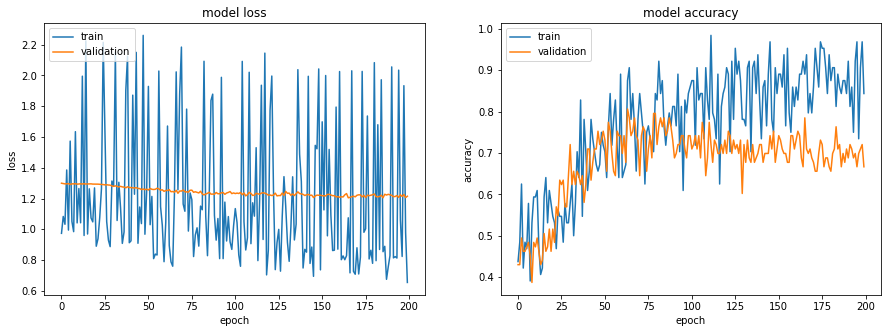

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(train_losses)
axs[0].plot(val_losses)
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(train_acc)
axs[1].plot(val_acc)
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

## Embed dataset in latent space

In [ ]:
EARLY_STOP = True

print(VARIATIONAL)

@tf.function
def embed(signals, variational=True):
  if variational:
    _, _, features, _, _ = Classifier(signals, training=False)
  else:
    _, _, features = Classifier(signals, training=False)
  return features

X_latent = []
X_val_latent = []

# load best weights
if EARLY_STOP:
  Classifier.load_weights("classifier.h5")
for idx in tqdm(range(X_train.shape[0])):
  latent = embed(X_train[idx:idx+1, :, :], VARIATIONAL)
  #print(latent.shape)
  X_latent.append(latent[0])
for idx in tqdm(range(X_val.shape[0])):
  latent = embed(X_val[idx:idx+1, :, :], VARIATIONAL)
  #print(latent.shape)
  X_val_latent.append(latent[0])
#print(np.array(X_latent).shape)

1000it [00:00, 11864.17it/s]


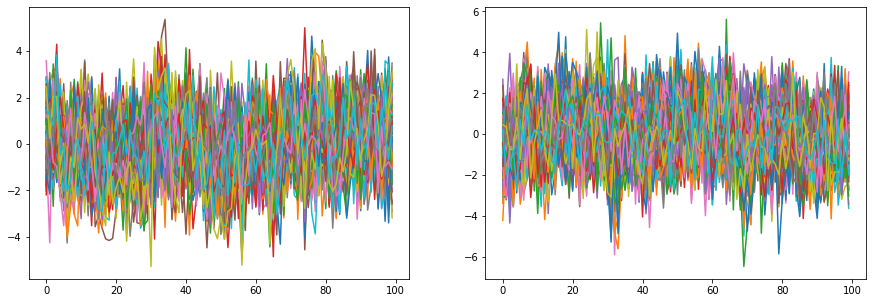

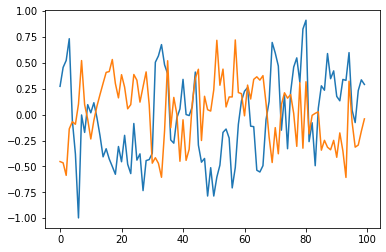

In [13]:
class_0 = []
class_1 = []
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for x, y in tqdm(zip(X_latent[:1000], Y_channeled[:1000])):
  x = x[:, 0]
  if y==0:
    class_0.append(x)
  else:
    class_1.append(x)

for i in range(200):
  axs[0].plot(class_0[i])
  axs[1].plot(class_1[i])
plt.show()

plt.close()
avg_0 = np.mean(np.array(class_0), axis=0)
avg_1 = np.mean(np.array(class_1), axis=0)
plt.plot(avg_0)
plt.plot(avg_1)
plt.show()

## PCA

(1751, 100)


(-10.0, 10.0)

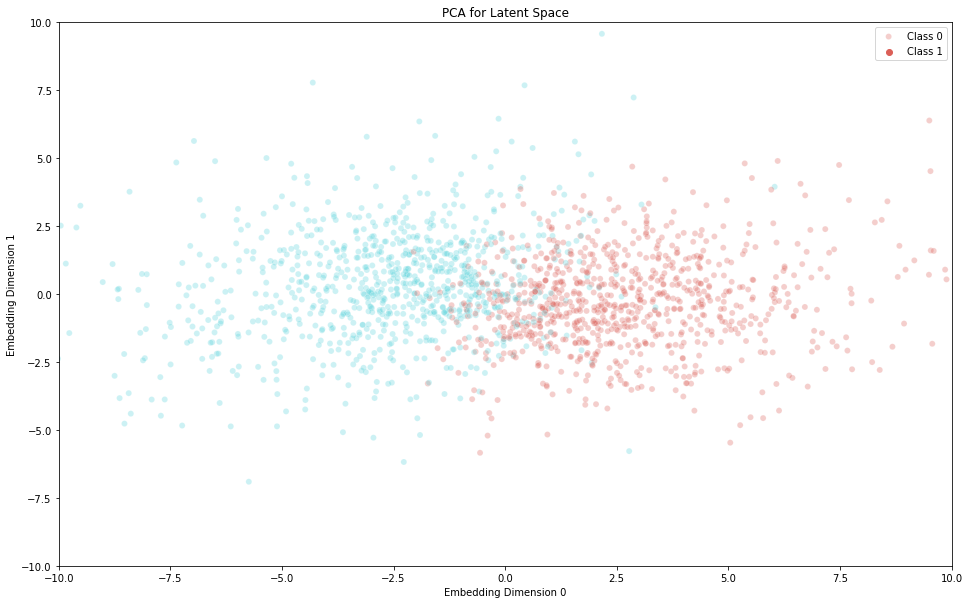

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_to_pca = [x[:, 0] for x in X_latent]
X_to_pca = np.array(X_to_pca)
print(X_to_pca.shape)
pca.fit(X_to_pca)

pca_results = pca.transform(X_to_pca)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_results[:,0], y=pca_results[:,1],
    hue=Y_train,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)
plt.title("PCA for Latent Space")
plt.legend(["Class 0", "Class 1"])
plt.xlabel("Embedding Dimension 0")
plt.ylabel("Embedding Dimension 1")
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [15]:
pca = PCA(n_components=70)
pca.fit(X_to_pca)
pca_results = pca.transform(X_to_pca)
print(sum(pca.explained_variance_ratio_))

0.8424128661863506


## Training on Latent Data

In [16]:
keras.backend.clear_session()
X_latent_dense = [sample[:, 0] for sample in X_latent]
X_latent_val_dense = [sample[:, 0] for sample in X_val_latent]

X_latent_conv = X_latent
X_latent_val_conv = X_val_latent

PRETRAINED = True

# regularizers seem to be a crapshoot
kreg = keras.regularizers.l2(0.0001)
areg = keras.regularizers.l2(0.0001)
act = 'selu'

def conv_classifier(inputs):
   # classifier
   # revert to 16 / [2, 2] for better performance lol
  FILTER_MUL = 16#16 # was 512, 128
  pools = [2, 2]#[2, 2]

  conv1 = layers.Conv1D(filters=FILTER_MUL * 2, kernel_size=32, activation=ACTIVATION, padding='same', name='C-c1', kernel_regularizer=kreg, activity_regularizer=areg)(inputs)
  drop1 = layers.Dropout(DROP_RATE, name='C-d1')(conv1)
  pool1 = layers.MaxPooling1D(pool_size=pools[0], name='C-p1')(drop1)

  conv2 = layers.Conv1D(filters=FILTER_MUL * 4, kernel_size=32, activation=ACTIVATION, padding='same', name='C-c2', kernel_regularizer=kreg, activity_regularizer=areg)(pool1)
  drop2 = layers.Dropout(DROP_RATE, name='C-d2')(conv2)
  pool2 = layers.MaxPooling1D(pool_size=pools[1], name='C-p2')(drop2)

  flat1 = layers.Flatten(name='C-f1')(pool2)
  classification = layers.Dense(1, name='C-classifications')(flat1)

  return classification

def classifier(inputs):
  # LINEAR
  d1 = layers.Dense(50, activation=act, kernel_regularizer=kreg, activity_regularizer=areg)(inputs)
  d1 = layers.Dropout(DROP_RATE)(d1)
  d2 = layers.Dense(25, activation=act, kernel_regularizer=kreg, activity_regularizer=areg)(d1)
  d2 = layers.Dropout(DROP_RATE)(d2)
  prediction = layers.Dense(1)(d2)
  """
  #d1 = layers.Dense(50)(inputs)
  #d1 = layers.Dropout(DROP_RATE)(d1)
  d2 = layers.Dense(25, activation='relu')(inputs)
  d2 = layers.Dropout(DROP_RATE)(d2)
  prediction = layers.Dense(1)(d2)
  """
  return prediction

latent_in=layers.Input(X_latent_dense[0].shape)
latent_conv_in=layers.Input(X_latent_conv[0].shape)
decisions = conv_classifier(latent_conv_in)#classifier(latent_in)
LatentClassifier = keras.Model(inputs=latent_conv_in, outputs=decisions)#inputs=latent_in, outputs=decisions)

if PRETRAINED:
  for trained_layer in Classifier.layers:
    #print(layer.get_config(), layer.get_weights())
    for untrained_layer in LatentClassifier.layers:
      if untrained_layer.name == trained_layer.name:
        untrained_layer.set_weights(trained_layer.get_weights())
        print(trained_layer)

LatentClassifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
C-c1 (Conv1D)                (None, 100, 32)           1056      
_________________________________________________________________
C-d1 (Dropout)               (None, 100, 32)           0         
_________________________________________________________________
C-p1 (MaxPooling1D)          (None, 50, 32)            0         
_________________________________________________________________
C-c2 (Conv1D)                (None, 50, 64)            65600     
_________________________________________________________________
C-d2 (Dropout)               (None, 50, 64)            0         
_________________________________________________________________
C-p2 (MaxPooling1D)          (None, 25, 64)           

In [17]:
LR = 0.0005 / 10.0 #* 10.0
LatentClassifier.compile(optimizer=keras.optimizers.Adam(LR), loss="binary_crossentropy", metrics=["acc"])
#print(X_latent_dense)
#print(Y_train)
NUM_EPOCHS = 50
BATCH_SIZE = 64
X_latent_fit = np.array(X_latent_conv)#dense)
X_latent_val_fit = np.array(X_latent_val_conv)#dense)
Y_fit = np.array(Y_train) 
Y_val_fit = np.array(Y_val)
history = LatentClassifier.fit(X_latent_fit, Y_fit, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_latent_val_fit, Y_val_fit))

Epoch 1/50
28/28 [==============================] - 0s 16ms/step - loss: 0.6261 - acc: 0.9046 - val_loss: 1.2829 - val_acc: 0.7849
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.5811 - acc: 0.9143 - val_loss: 1.1444 - val_acc: 0.7849
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.5382 - acc: 0.9126 - val_loss: 1.1338 - val_acc: 0.7849
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4902 - acc: 0.9103 - val_loss: 1.1241 - val_acc: 0.7742
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4995 - acc: 0.9155 - val_loss: 1.1197 - val_acc: 0.7742
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4996 - acc: 0.9138 - val_loss: 1.1190 - val_acc: 0.7849
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.5643 - acc: 0.9132 - val_loss: 1.1193 - val_acc: 0.7742
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 0.4589 - acc: 0.9

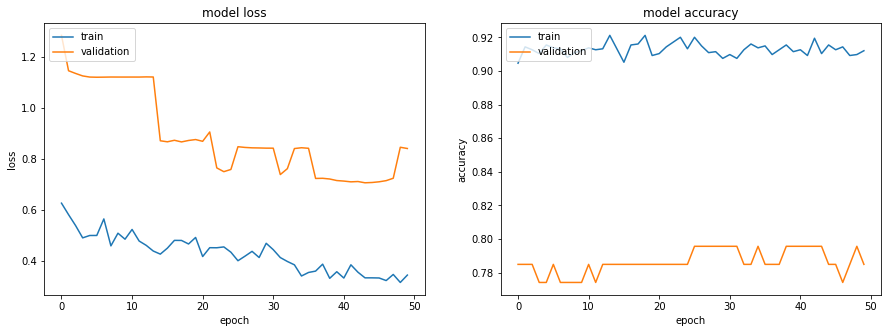

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(history.history['acc'])
axs[1].plot(history.history['val_acc'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

## TSNE
visualize the latent data, preserving class clustering

## 2D

In [ ]:
from sklearn.manifold import TSNE
# was two components
# 2, 1, 60, 150, 1k
tsne = TSNE(n_components=2, verbose=1, perplexity=60, learning_rate=150, n_iter=1000)#perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_latent_dense)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1751 samples in 0.014s...
[t-SNE] Computed neighbors for 1751 samples in 0.645s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1751
[t-SNE] Computed conditional probabilities for sample 1751 / 1751
[t-SNE] Mean sigma: 3.165893


In [ ]:
print(len(X_latent_dense))
print(Y_fit.shape)

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=Y_train,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)
plt.title("t-SNE for Latent Space")
plt.legend(["Class 0", "Class 1"])
plt.xlabel("Embedding Dimension 0")
plt.ylabel("Embedding Dimension 1")
plt.xlim([-10, 10])
plt.ylim([-10, 10])

## 3D

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=100, learning_rate=100, n_iter=750)#perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_latent_dense)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1751 samples in 0.011s...
[t-SNE] Computed neighbors for 1751 samples in 0.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1751
[t-SNE] Computed conditional probabilities for sample 1751 / 1751
[t-SNE] Mean sigma: 0.908105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.467300
[t-SNE] KL divergence after 750 iterations: 2.856113


In [ ]:
print(tsne_results.shape)
class_0 = []
class_1 = []
for idx in tqdm(range(tsne_results.shape[0])):
  x = tsne_results[idx]
  y = Y_train[idx]
  #print(y)
  if y==0:
    class_0.append(x)
  else:
    class_1.append(x)

class_0 = np.array(class_0)
class_1 = np.array(class_1)

100%|██████████| 1751/1751 [00:00<00:00, 345643.18it/s]

(1751, 3)


(-100.0, 100.0)

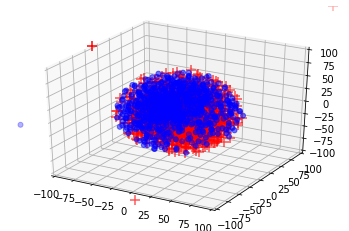

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], c= 'r', s = 100, marker='+')
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], c= 'b', s = 100, marker='.')
ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.set_zlim([-100, 100])

# Classification

## Random Forest

In [ ]:
print(X.shape)
print(Y.shape)

md = []
ne = []
avg = []
for max_depth in tqdm([100, 150, 200]):#tqdm([1, 5, 10, 50, 100, None]):
  for n_estimators in tqdm([100, 150, 200, 250]):#tqdm([50, 75, 100, 200]):

    clf=RandomForestClassifier(random_state = 42, class_weight="balanced", criterion = 'gini', max_depth = max_depth, max_features = 'auto', n_estimators = n_estimators)

    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    output = cross_validate(clf, X, Y, cv=k_fold, scoring = 'roc_auc', return_estimator =True)

    print(output.keys())
    print(output['test_score'])
    avg_score = sum(output['test_score']) / len(output['test_score'])
    print(avg_score)
    avg.append(avg_score)
    md.append(max_depth)
    ne.append(n_estimators)





  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/4 [00:00<?, ?it/s]

(1844, 2811)
(1844,)







 25%|██▌       | 1/4 [00:24<01:12, 24.31s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52096063 0.55628672 0.52470623 0.50981256 0.50831487]
0.524016203739665







 50%|█████     | 2/4 [01:00<00:56, 28.02s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52007932 0.59747356 0.51460047 0.50377519 0.50174273]
0.5275342535532107







 75%|███████▌  | 3/4 [01:49<00:34, 34.12s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.51925676 0.59220035 0.51963866 0.49823726 0.49147836]
0.5241622795052658







100%|██████████| 4/4 [02:47<00:00, 41.94s/it]




 33%|███▎      | 1/3 [02:47<05:35, 167.75s/it]




  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.5322121  0.57574912 0.52135723 0.50218873 0.50729582]
0.527760599907382







 25%|██▌       | 1/4 [00:22<01:08, 23.00s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52096063 0.55628672 0.52470623 0.50981256 0.50831487]
0.524016203739665







 50%|█████     | 2/4 [00:57<00:52, 26.36s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52007932 0.59747356 0.51460047 0.50377519 0.50174273]
0.5275342535532107







 75%|███████▌  | 3/4 [01:42<00:31, 31.99s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.51925676 0.59220035 0.51963866 0.49823726 0.49147836]
0.5241622795052658







100%|██████████| 4/4 [02:38<00:00, 39.61s/it]




 67%|██████▋   | 2/3 [05:26<02:44, 164.96s/it]




  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.5322121  0.57574912 0.52135723 0.50218873 0.50729582]
0.527760599907382







 25%|██▌       | 1/4 [00:22<01:07, 22.42s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52096063 0.55628672 0.52470623 0.50981256 0.50831487]
0.524016203739665







 50%|█████     | 2/4 [00:55<00:51, 25.75s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.52007932 0.59747356 0.51460047 0.50377519 0.50174273]
0.5275342535532107







 75%|███████▌  | 3/4 [01:40<00:31, 31.36s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.51925676 0.59220035 0.51963866 0.49823726 0.49147836]
0.5241622795052658







100%|██████████| 4/4 [02:35<00:00, 38.98s/it]




100%|██████████| 3/3 [08:02<00:00, 160.70s/it]

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
[0.5322121  0.57574912 0.52135723 0.50218873 0.50729582]
0.527760599907382






100%|██████████| 3/3 [00:00<00:00, 90.29it/s]

    num estimators  max depth  avg test score
0              100        100        0.524016
1              150        100        0.527534
2              200        100        0.524162
3              250        100        0.527761
4              100        150        0.524016
5              150        150        0.527534
6              200        150        0.524162
7              250        150        0.527761
8              100        200        0.524016
9              150        200        0.527534
10             200        200        0.524162
11             250        200        0.527761
[100, 150, 200, 250]
[0.524016203739665, 0.5275342535532107, 0.5241622795052658]
[100, 150, 200, 250]
[0.524016203739665, 0.5275342535532107, 0.5241622795052658]
[100, 150, 200, 250]
[0.524016203739665, 0.5275342535532107, 0.5241622795052658]


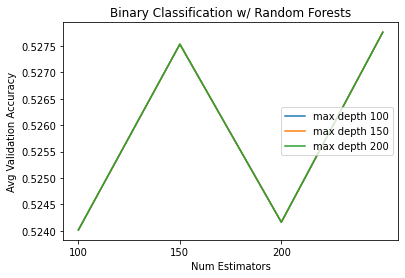

In [ ]:
import pandas as pd

df = pd.DataFrame({'num estimators': ne, 'max depth': md, 'avg test score': avg})
print(df)
df.to_csv('scores.csv')

x = [100, 150, 200, 250]#[50, 75, 100]
for max_depth in tqdm([100, 150, 200]):#tqdm([1., 5., 10., 50., 100.]):

  score_50 = df[(df['max depth'] == max_depth) & (df['num estimators'] == 100)]['avg test score'].iloc[0]
  score_75 = df[(df['max depth'] == max_depth) & (df['num estimators'] == 150)]['avg test score'].iloc[0]
  score_100 = df[(df['max depth'] == max_depth) & (df['num estimators'] == 200)]['avg test score'].iloc[0]
  score_150 = df[(df['max depth'] == max_depth) & (df['num estimators'] == 250)]['avg test score'].iloc[0]
  print(x)
  print([score_50, score_75, score_100])
  plt.plot(x, [score_50, score_75, score_100, score_150])
plt.title("Binary Classification w/ Random Forests")
plt.xlabel("Num Estimators")
plt.xticks([100, 150, 200])#[50, 75, 100])
plt.ylabel("Avg Validation Accuracy")
plt.legend(["max depth " + str(int(max_depth)) for max_depth in [100, 150, 200, 250]])#[1., 5., 10., 50., 100.]])
plt.show()

## Using `tf.keras`

In [ ]:
print(np.array(X_channeled).shape)

(2240, 313, 3)


In [ ]:
print(X_more.shape)

(6720, 313, 1)


In [ ]:
print(X_channeled[0].shape)

(937, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
X_channeled = np.array(X_channeled)
SAMPLE_LENGTH = X_channeled.shape[1]
NUM_CHANNELS = X_channeled.shape[2]
BATCH_SIZE = 128
"""
SAMPLE_LENGTH = X_more.shape[1]#X.shape[1]
NUM_CHANNELS = 1
BATCH_SIZE = 128

X = X.reshape((X.shape[0], X.shape[1], 1))
# trim last sample lol
#X_more = X_more[:, 0]
#X_more = X_more.reshape((X_more.shape[0], X_more.shape[1], 1))
# this doesn't make as much sense for a convnet
input_shape=(936, 3)#(SAMPLE_LENGTH)#, 1)#(SAMPLE_LENGTH, 1)#(BATCH, 313, 3) #(939,1)
# single-channel EEG: split across
print(input_shape)
print(X.shape)
print(X_more.shape)

# preproc x_channeled
X_channeled = [x[:-1, :] for x in X_channeled]
X_channeled = np.array(X_channeled)

if SPECTROGRAM:
  spectrogram_in_shape = (Sxx[0].shape[0], Sxx[0].shape[1], 1)
  print(spectrogram_in_shape)
if GEN_CWT:
  cwt_shape = (CWT[0].shape[0], CWT[0].shape[1], 1)

(936, 3)
(1844, 2811, 1)
(5532, 937)


In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.Sequential(
    [
        layers.Conv1D(filters=128, kernel_size=64, activation='relu', input_shape=input_shape, padding='same'),
        layers.Dropout(0.3),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=32, activation='relu', padding='same'),
        layers.Dropout(0.3),
        layers.MaxPooling1D(pool_size=4),
        layers.Conv1DTranspose(filters=128, kernel_size=32, activation='relu', padding='same'),
        layers.Dropout(0.3),
        layers.UpSampling1D(4),
        layers.Conv1DTranspose(filters=128, kernel_size=64, activation='relu', padding='same'),
        layers.Dropout(0.3),
        layers.UpSampling1D(2),
        layers.Conv1D(filters=3, kernel_size=1, activation='sigmoid')
        #layers.Flatten(),
        #layers.Dense(150, activation='relu', input_shape=(313, )),
        #layers.Dense(100, activation='relu'),
        #layers.Dense(50, activation='relu'),
        #layers.Dense(25, activation='relu'),
        #layers.Dense(1, activation='sigmoid')
    ]
)


"""
model = keras.models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=cwt_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
"""
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 936, 128)          24704     
_________________________________________________________________
dropout_4 (Dropout)          (None, 936, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 468, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 468, 128)          524416    
_________________________________________________________________
dropout_5 (Dropout)          (None, 468, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 117, 128)          0         
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 117, 128)         

In [ ]:
print(X.shape)

(1844, 2811, 1)


In [ ]:
#print(X_channeled[:2])
#print(Y_channeled[:2])
x_train = X_channeled
y_train = Y_channeled
onehots = y_train
#plt.plot(x_train[0][0, :])
# one-hot for keras
# extremely shitty OHE-ing bc lazy
#onehots = [ np.array([1.0, 0.0]) if y == 0 else np.array([0.0, 1.0]) for y in y_train]
#print(onehots[:2])
#y = keras.to_categorical()
#x_train = np.array(x_train)

#print(x_train.shape)

#x_train = np.rollaxis(x_train, 1, 2)
#x_train = np.swapaxes(x_train, 1, 2)
onehots = np.array(onehots)
#print(x_train.shape)
#print(onehots.shape)

print(np.array(Y_more).shape)
#print(np.array(Sxx).shape)
if SPECTROGRAM:
  Sxx = np.array(Sxx)
if GEN_CWT:
  CWT = np.array(CWT)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['mse'])
#model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
model.summary()
model.fit(X_channeled, X_channeled, shuffle=True, epochs=30, batch_size=16)
"""
model.fit(X_more, onehots, shuffle=True,#CWT, Y_more, shuffle=True,
        epochs=100, batch_size=32,
)
"""

(5532,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 936, 128)          24704     
_________________________________________________________________
dropout_4 (Dropout)          (None, 936, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 468, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 468, 128)          524416    
_________________________________________________________________
dropout_5 (Dropout)          (None, 468, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 117, 128)          0         
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 117, 128) 

'\nmodel.fit(X_more, onehots, shuffle=True,#CWT, Y_more, shuffle=True,\n        epochs=100, batch_size=32,\n)\n'

### Testing Reconstruction

In [ ]:
preds = model.predict(X_channeled[:10, :, :])
print(preds.shape)

(10, 936, 3)


In [ ]:
autohstack((eeg_0, eeg_1, eeg_2))

(936, 3)


Text(0.5, 1.0, 'Channel 2')

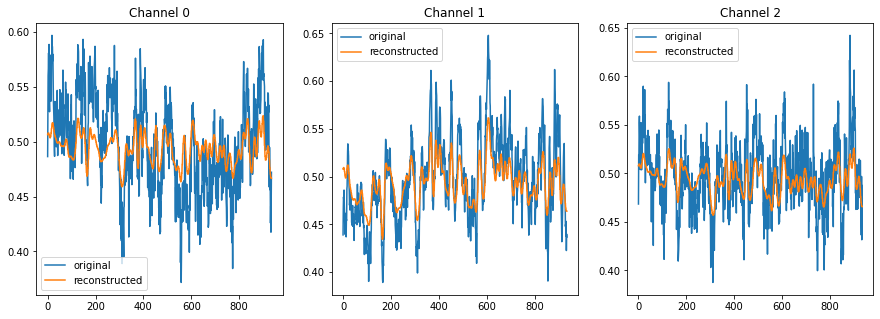

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(X_channeled[0, :, 0])
axs[0].plot(preds[0, :, 0])
axs[0].legend(["original", "reconstructed"])
axs[0].set_title("Channel 0")

axs[1].plot(X_channeled[0, :, 1])
axs[1].plot(preds[0, :, 1])
axs[1].legend(["original", "reconstructed"])
axs[1].set_title("Channel 1")

axs[2].plot(X_channeled[0, :, 2])
axs[2].plot(preds[0, :, 2])
axs[2].legend(["original", "reconstructed"])
axs[2].set_title("Channel 2")

### Reconstruct entire dataset

In [ ]:
preds = []
idx = 0
for img_idx in tqdm(range(int(X_channeled.shape[0] / 32))):
  pred = model.predict(X_channeled[idx:idx+32, :, :])
  #preds.append(pred)
  for i in range(32):
    preds.append(pred[i])
  idx += 32

print(len(preds))

100%|██████████| 57/57 [00:01<00:00, 28.81it/s]

1824


In [ ]:
print(preds[0].shape)

reconstructed_X = [np.hstack((cx[:, 0], cx[:, 1], cx[:, 2])) for cx in preds]
print(np.array(reconstructed_X).shape)
reconstructed_X = np.array(reconstructed_X)

(936, 3)
(1824, 2808)


## LSTM

In [ ]:
print(X_channeled[0].shape)

(936, 3)


In [ ]:
keras.backend.clear_session()

model = keras.Sequential()
DIM = 100
DENSE = 25
LR=0.0001
BATCH_SIZE=8
n_timesteps = X_channeled.shape[1]
n_features = X_channeled.shape[-1]
n_outputs = 1
model.add(layers.LSTM(DIM, input_shape=(n_timesteps,n_features)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(DENSE, activation='relu'))
model.add(layers.Dense(n_outputs, activation='sigmoid'))

model.summary()
opt = keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(np.array(X_channeled), onehots, shuffle=True, epochs=30, batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               41600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                2525      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 44,151
Trainable params: 44,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
231/231 [==============================] - 7s 29ms/step - loss: 0.6958 - accuracy: 0.4951
Epoch 2/30
231/231 [==============================] - 7s 29ms/step - loss: 0.6943 - accuracy: 0.5000
Epoch 3/30
 13/231 [>...........................

KeyboardInterrupt: ignored

## Spectrograms and CWT

In [ ]:
from scipy.signal import spectrogram
from scipy.fft import fftshift

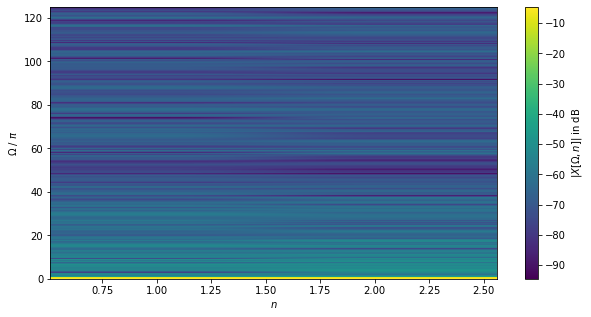

In [ ]:
L = 512  # length of one segment
overlap = 256  # overlap between segments
Fs=250
plt.figure(figsize = (10, 5))
plt.specgram(X[0], NFFT=L, Fs=Fs, noverlap=overlap, sides='onesided')#x_train[0, :, 0], NFFT=L, Fs=Fs, noverlap=overlap, sides='onesided')
plt.xlabel(r'$n$')
plt.ylabel(r'$\Omega$ / $\pi$')
cb = plt.colorbar()
cb.set_label(r'$|X[\Omega,n]|$ in dB')
plt.autoscale(tight=True)

In [ ]:
f, t, Sxx = spectrogram(X[0, :, 0], 250)
print(x_train[0, :, 0].shape)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(2240, 939)


IndexError: ignored